# Modelos

En este *notebook* se va a ajustar el modelo más sencillo posible: un modelo de **tendencia en el tiempo**.

In [13]:
# =============================================================================
#
# Pronostico time trend + dummy seasonal
#
# =============================================================================

#
# Carga de datos
#
import nbimporter  #  type: ignore
import functions  #  type: ignore


df_orig = functions.load_data()
df_orig.head()

,yt_true
date,
1946-01-01,890
1946-02-01,992
1946-03-01,979
1946-04-01,959
1946-05-01,1110


In [14]:
#
# Componentes de tendencia lineal
#
df_orig = functions.add_linear_trend_component(df_orig)
df_orig.head(10)

,yt_true,trend
date,,
1946-01-01,890,0
1946-02-01,992,1
1946-03-01,979,2
1946-04-01,959,3
1946-05-01,1110,4
1946-06-01,1546,5
1946-07-01,1539,6
1946-08-01,3401,7
1946-09-01,2092,8


In [15]:
# Componentes estacionales
#
df_orig = functions.add_month_component(df_orig)
df_orig.head(15)  

,yt_true,trend,month
date,,,
1946-01-01,890,0,1
1946-02-01,992,1,2
1946-03-01,979,2,3
1946-04-01,959,3,4
1946-05-01,1110,4,5
1946-06-01,1546,5,6
1946-07-01,1539,6,7
1946-08-01,3401,7,8
1946-09-01,2092,8,9


In [16]:
#
# Particionamiento de los datos
#
(
    X_complete,
    y_complete,
    X_train,
    y_train,
    X_test,
    y_test,
) = functions.train_test_split(
    df=df_orig,
    x_columns=["trend", "month"],
    y_column="yt_true",
)

Se crea un *pipeline* que recibe como argumento el grado del polinomio. Luego, en la definición como tal del *pipeline*, se comienza con un transformador de columnas que empaqueta un polinomio y un escalador para la columna `trend` (como se indica en la línea 29). Luego, se aplicará un *one hot encoder* a la columna del mes, `month`, y por último, se ajusta la regresión lineal.

In [17]:
#
# Especificación del Modelo
#
from sklearn.pipeline import Pipeline  #  type: ignore
from sklearn.preprocessing import (  #  type: ignore
    PolynomialFeatures,
    OneHotEncoder,
    MinMaxScaler,
)
from sklearn.linear_model import LinearRegression  #  type: ignore
from sklearn.compose import ColumnTransformer  #  type: ignore


def create_pipeline(degree):
    pipeline = Pipeline(
        [
            (
                "preprocessor",
                ColumnTransformer(
                    [
                        (
                            "trend",
                            Pipeline(
                                [
                                    ("poly", PolynomialFeatures(degree=degree)),
                                    ("scaler", MinMaxScaler()),
                                ]
                            ),
                            ["trend"],
                        ),
                        ("seasonal", OneHotEncoder(), ["month"]),
                    ]
                ),
            ),
            ("regressor", LinearRegression()),
        ]
    )

    return pipeline

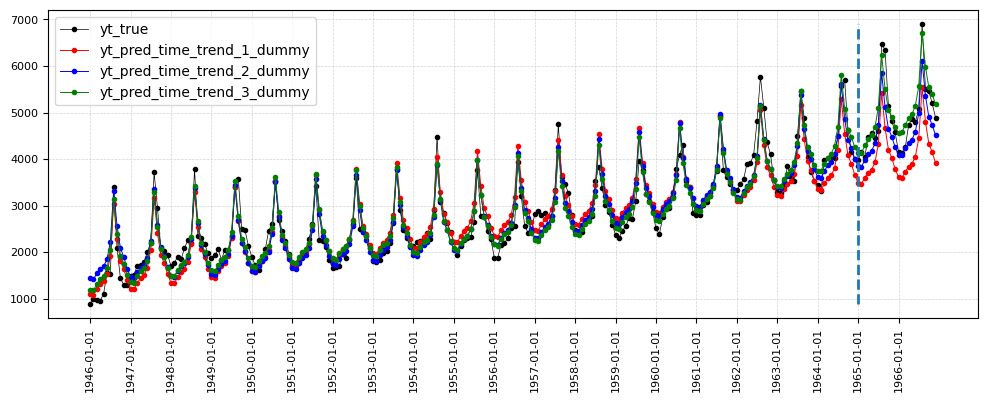

In [18]:
#
# Entrenamiento y pronóstico
#

for grado in range(1, 4):
    pipeline = create_pipeline(degree=grado)
    pipeline.fit(X_train, y_train)
    df_orig[f"yt_pred_time_trend_{grado}_dummy"] = pipeline.predict(X_complete)

functions.plot_time_series(df_orig)

In [19]:
#
# Métricas de error
#
metrics = functions.compute_evaluation_metrics(df_orig)
functions.save_metrics(metrics)
metrics

,Metrics,yt_pred_time_trend_1_dummy,yt_pred_time_trend_2_dummy,yt_pred_time_trend_3_dummy
0,MSE Train,103217.67,78075.48,68046.65
1,MSE Test,738282.04,190079.09,107316.25
2,MAE Train,259.03,213.47,202.37
3,MAE Test,804.13,341.66,261.93


In [20]:
#
# Almacenamiento de los resultados
#
functions.save_forecasts(df_orig)  